# Data Analysis Experiment: Machine Learning

[View this notebook in nbviewer](https://nbviewer.org/github/Data-Science-for-Linguists-2023/AITA-Blame-Analysis/blob/main/code/data_analysis_experiments.ipynb)

Note: The contents of this notebook ultimately showcase that training a classification model on this data is difficult and provides results only marginally above the base accuracy. However, I decided to still include this notebook as it showcases some meaningful problem solving strategies and critical thinking about the issues presented. Someday, I may return to this project and attempt again to generate results from a machine learning model.

## Set Up

In [1]:
import numpy as np
import pandas as pd
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

As the size of this data set is already fairly limited, I intend to use a stratified K-fold to analyze the success of the models I build on a larger set of testing data than if I were to split the corpus into training and testing sets normally.

In [2]:
analysis_df = pd.read_csv('../data/aita_data.csv')

In [3]:
analysis_df.head()

,Unnamed: 0,AuthorID,Title,Text,Ruling,CommentCount,Score,UpvoteRatio
0,0,1,AITA for sleeping during the day?,"I honestly thought what I was doing was fine, ...",Not the A-hole,34,7,0.82
1,2,0,AITAH for refusing to change out of my semi-se...,My boyfriend was FaceTiming his cousin and his...,Not the A-hole,23,8,0.78
2,6,2,AITA for not helping my neighbor?,I (M26) live in a large apartment complex with...,Not the A-hole,253,1016,0.97
3,9,3,AITA for threatening to lock my housemate's wi...,I'll keep it short; my housemate moved in arou...,Everyone Sucks,34,4,0.76
4,25,4,AITA for allowing my bio dad and his wife to b...,I found out that I am pregnant about 5 1/2 mon...,Not the A-hole,62,46,0.88


In [4]:
analysis_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9414 entries, 0 to 9413
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    9414 non-null   int64  
 1   AuthorID      9414 non-null   int64  
 2   Title         9414 non-null   object 
 3   Text          9414 non-null   object 
 4   Ruling        9414 non-null   object 
 5   CommentCount  9414 non-null   int64  
 6   Score         9414 non-null   int64  
 7   UpvoteRatio   9414 non-null   float64
dtypes: float64(1), int64(4), object(3)
memory usage: 588.5+ KB


In [5]:
analysis_df.Ruling.value_counts()

Not the A-hole     7180
Asshole            1399
No A-holes here     471
Everyone Sucks      364
Name: Ruling, dtype: int64

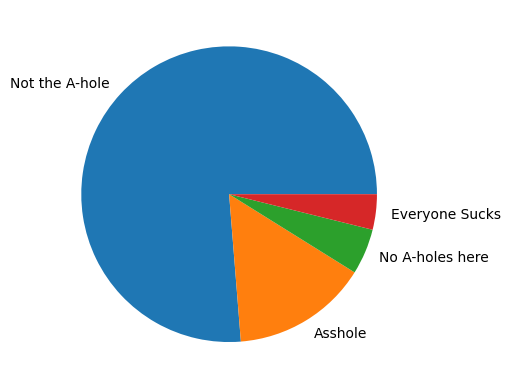

In [6]:
rulings_graph = plt.pie(analysis_df.Ruling.value_counts(), labels=["Not the A-hole", "Asshole", "No A-holes here", "Everyone Sucks"])
plt.show()

From this breakdown of the posts, I am weary of the possible results skewing incredibly heavily toward Not the A-hole. Is there enough data on Everyone Sucks and No A-holes here to have them represented in the predictions?

## Question: How similarly, and therefore predictably, are posts of a given ruling written?

### Practically: How accurate of a machine learning classification model can I generate from just the text in this corpus?

### Using MultinomialNB on all data

In [7]:
docs = analysis_df["Text"]
outputs = analysis_df["Ruling"]
titles = analysis_df["Title"]
skf = StratifiedKFold(n_splits=10)

In [8]:
accuracy_scores = []
total_pred = []
total_test = []

In [9]:
for train_idx, test_idx in skf.split(docs, outputs):
    x_train, x_test = docs.iloc[train_idx], docs.iloc[test_idx]
    y_train, y_test = outputs.iloc[train_idx], outputs.iloc[test_idx]
    
    vectorizer = TfidfVectorizer(max_features=1500, stop_words="english")
    X_train_tfidf = vectorizer.fit_transform(x_train)
    X_test_tfidf = vectorizer.transform(x_test)
    
    nbclass = MultinomialNB()
    nbclass.fit(X_train_tfidf, y_train)
    y_pred = nbclass.predict(X_test_tfidf)
    
    accuracy_scores.append(accuracy_score(y_test, y_pred))
    total_pred.extend(y_pred)
    total_test.extend(y_test)

In [10]:
accuracy_scores

[0.7622080679405521,
 0.7622080679405521,
 0.7622080679405521,
 0.7622080679405521,
 0.7630180658873539,
 0.7630180658873539,
 0.7630180658873539,
 0.7630180658873539,
 0.7630180658873539,
 0.7630180658873539]

If the data set was comprised of equal numbers of posts per ruling, the base accuracy here would be 25%. However, because the data set maintains such a higher number of Not the A-hole posts, I presume this statistic is inflated by overpredicting Not the A-hole. The precision on the model looks promising, though,

In [11]:
set(total_pred)

{'Not the A-hole'}

And as it turns out, this is the statistic for when you _only_ guess Not the A-hole! So even though numerically it looks like a success, the model isn't really doing anything! Let's try a few tweaks to try and heighten the accuracy. I'm going to increase the number of features and include bigrams to try and get more variance in the features included for each ruling.

In [12]:
accuracy_scores = []
total_pred = []
total_test = []

In [13]:
for train_idx, test_idx in skf.split(docs, outputs):
    x_train, x_test = docs.iloc[train_idx], docs.iloc[test_idx]
    y_train, y_test = outputs.iloc[train_idx], outputs.iloc[test_idx]
    
    vectorizer = TfidfVectorizer(max_features=5000, stop_words=None, ngram_range=(1,2))
    X_train_tfidf = vectorizer.fit_transform(x_train)
    X_test_tfidf = vectorizer.transform(x_test)
    
    nbclass = MultinomialNB()
    nbclass.fit(X_train_tfidf, y_train)
    y_pred = nbclass.predict(X_test_tfidf)
    
    accuracy_scores.append(accuracy_score(y_test, y_pred))
    total_pred.extend(y_pred)
    total_test.extend(y_test)

In [14]:
accuracy_scores

[0.7622080679405521,
 0.7622080679405521,
 0.7622080679405521,
 0.7622080679405521,
 0.7630180658873539,
 0.7630180658873539,
 0.7630180658873539,
 0.7630180658873539,
 0.7630180658873539,
 0.7630180658873539]

In [15]:
set(total_pred)

{'Not the A-hole'}

Still nothing!

### Using MultinomialNB on subset of data

Because of how skewed the data set is, I don't think it is possible to tune a model that really factors in the other rulings, especially when using a method such as K-Fold which randomizes the number of each ruling there is within a particular test. It isn't impossible that there are some groups that do not even have a No A-holes Here or Everything Sucks post.

As such, I am narrowing this portion of the project to only be concerned about the binary of Asshole versus Not the A-hole. To make it more fair, I am going to take a random sample of Not the A-hole posts equal to the number of total Asshole posts to create an even subset of data.

In [16]:
yta_nta_df = analysis_df[analysis_df["Ruling"] == "Not the A-hole"].sample(n=1399)
yta_nta_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1399 entries, 2525 to 5436
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    1399 non-null   int64  
 1   AuthorID      1399 non-null   int64  
 2   Title         1399 non-null   object 
 3   Text          1399 non-null   object 
 4   Ruling        1399 non-null   object 
 5   CommentCount  1399 non-null   int64  
 6   Score         1399 non-null   int64  
 7   UpvoteRatio   1399 non-null   float64
dtypes: float64(1), int64(4), object(3)
memory usage: 98.4+ KB


In [17]:
yta_nta_df["Ruling"].value_counts()

Not the A-hole    1399
Name: Ruling, dtype: int64

In [18]:
yta_nta_df = pd.concat([yta_nta_df,
                        analysis_df[analysis_df["Ruling"] == "Asshole"]])
yta_nta_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2798 entries, 2525 to 9409
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    2798 non-null   int64  
 1   AuthorID      2798 non-null   int64  
 2   Title         2798 non-null   object 
 3   Text          2798 non-null   object 
 4   Ruling        2798 non-null   object 
 5   CommentCount  2798 non-null   int64  
 6   Score         2798 non-null   int64  
 7   UpvoteRatio   2798 non-null   float64
dtypes: float64(1), int64(4), object(3)
memory usage: 196.7+ KB


In [19]:
yta_nta_df.Ruling.value_counts()

Not the A-hole    1399
Asshole           1399
Name: Ruling, dtype: int64

I will make a function to run through the model so that I can more easily try a variety of parameters to see if I can improve the model at all.

In [20]:
def test_nb_accuracies(vectorizer, df):
    docs = df["Text"]
    outputs = df["Ruling"]
    skf = StratifiedKFold(n_splits=5)
    
    accuracy_scores = []
    total_pred = []
    total_test = []

    for train_idx, test_idx in skf.split(docs, outputs):
        x_train, x_test = docs.iloc[train_idx], docs.iloc[test_idx]
        y_train, y_test = outputs.iloc[train_idx], outputs.iloc[test_idx]

        X_train_tfidf = vectorizer.fit_transform(x_train)
        X_test_tfidf = vectorizer.transform(x_test)

        nbclass = MultinomialNB()
        nbclass.fit(X_train_tfidf, y_train)
        y_pred = nbclass.predict(X_test_tfidf)

        accuracy_scores.append(accuracy_score(y_test, y_pred))
        total_pred.extend(y_pred)
        total_test.extend(y_test)
    
    return accuracy_scores, total_pred, total_test

In [21]:
accuracy_scores, total_pred, total_test = test_nb_accuracies(TfidfVectorizer(max_features=1500, stop_words="english"), yta_nta_df)
print(set(total_pred))
print(accuracy_scores)
print(np.average(accuracy_scores))

{'Asshole', 'Not the A-hole'}
[0.5553571428571429, 0.5714285714285714, 0.5821428571428572, 0.6010733452593918, 0.5796064400715564]
0.577921671351904


57.8% accuracy is slightly better than the base accuracy...

In [22]:
accuracy_scores, total_pred, total_test = test_nb_accuracies(TfidfVectorizer(max_features=7500, stop_words="english"), yta_nta_df)
print(accuracy_scores)
print(np.average(accuracy_scores))

[0.5517857142857143, 0.5607142857142857, 0.5446428571428571, 0.5706618962432916, 0.5796064400715564]
0.561482238691541


In [23]:
accuracy_scores, total_pred, total_test = test_nb_accuracies(TfidfVectorizer(max_features=10000, stop_words="english", ngram_range=(1,2)), yta_nta_df)
print(accuracy_scores)
print(np.average(accuracy_scores))

[0.5410714285714285, 0.5714285714285714, 0.5571428571428572, 0.5706618962432916, 0.5617173524150268]
0.560404421160235


In [24]:
accuracy_scores, total_pred, total_test = test_nb_accuracies(TfidfVectorizer(max_features=10000, stop_words=None, ngram_range=(1,2)), yta_nta_df)
print(accuracy_scores)
print(np.average(accuracy_scores))

[0.55, 0.5660714285714286, 0.5732142857142857, 0.5974955277280859, 0.5796064400715564]
0.5732775364170714


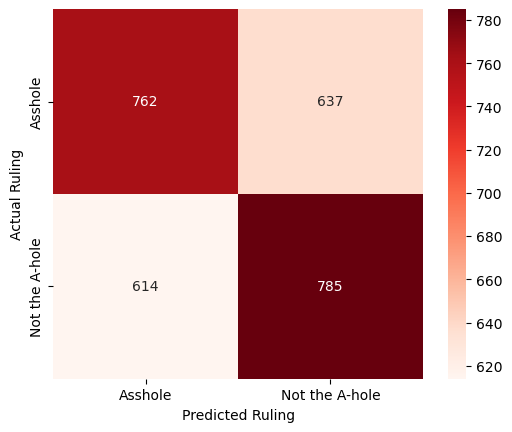

In [106]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(total_test, total_pred)
sns.heatmap(mat, square=True, annot=True, fmt="d", cmap="Reds", xticklabels=["Asshole", "Not the A-hole"], yticklabels=["Asshole", "Not the A-hole"])
plt.xlabel("Predicted Ruling")
plt.ylabel("Actual Ruling")
plt.savefig('../figures/classification_succes.png')
plt.show()

I can't seem to find a combination of parameters that reaches above 60%. From the heatmap, the model is guessing either ruling roughly equally. It's an improvement from the start, but still could be significantly better. I wonder if using SVC will improve it?

### Using SVC on subset of data

In [26]:
from sklearn.svm import SVC

In [27]:
def test_svc_accuracies(vectorizer, df):
    docs = df["Text"]
    outputs = df["Ruling"]
    skf = StratifiedKFold(n_splits=5)
    
    accuracy_scores = []
    total_pred = []
    total_test = []

    for train_idx, test_idx in skf.split(docs, outputs):
        x_train, x_test = docs.iloc[train_idx], docs.iloc[test_idx]
        y_train, y_test = outputs.iloc[train_idx], outputs.iloc[test_idx]

        X_train_tfidf = vectorizer.fit_transform(x_train)
        X_test_tfidf = vectorizer.transform(x_test)

        svcmodel = SVC(kernel="linear", C=1E3, random_state=0)
        svcmodel.fit(X_train_tfidf, y_train)
        y_pred = svcmodel.predict(X_test_tfidf)

        accuracy_scores.append(accuracy_score(y_test, y_pred))
        total_pred.extend(y_pred)
        total_test.extend(y_test)
    
    return accuracy_scores, total_pred, total_test

In [28]:
accuracy_scores, total_pred, total_test = test_svc_accuracies(TfidfVectorizer(max_features=1500, stop_words="english"), yta_nta_df)
print(set(total_pred))
print(accuracy_scores)
print(np.average(accuracy_scores))

{'Asshole', 'Not the A-hole'}
[0.5232142857142857, 0.5428571428571428, 0.5232142857142857, 0.552772808586762, 0.5259391771019678]
0.5335995399948888


In [29]:
accuracy_scores, total_pred, total_test = test_svc_accuracies(TfidfVectorizer(max_features=10000, stop_words="english", ngram_range=(1,2)), yta_nta_df)
print(accuracy_scores)
print(np.average(accuracy_scores))

[0.5339285714285714, 0.5482142857142858, 0.5392857142857143, 0.5670840787119857, 0.5313059033989267]
0.5439637107078967


In [30]:
accuracy_scores, total_pred, total_test = test_svc_accuracies(TfidfVectorizer(max_features=10000, stop_words=None, ngram_range=(1,2)), yta_nta_df)
print(accuracy_scores)
print(np.average(accuracy_scores))

[0.5571428571428572, 0.5607142857142857, 0.5464285714285714, 0.5313059033989267, 0.5223613595706619]
0.5435905954510605


In [31]:
accuracy_scores, total_pred, total_test = test_svc_accuracies(TfidfVectorizer(max_features=10000, stop_words=None, ngram_range=(1,3)), yta_nta_df)
print(accuracy_scores)
print(np.average(accuracy_scores))

[0.5410714285714285, 0.5571428571428572, 0.5714285714285714, 0.5420393559928444, 0.5241502683363148]
0.5471664962944033


In [32]:
accuracy_scores, total_pred, total_test = test_svc_accuracies(TfidfVectorizer(max_df=0.25, max_features=10000, stop_words=None, ngram_range=(1,2)), yta_nta_df)
print(accuracy_scores)
print(np.average(accuracy_scores))

[0.5660714285714286, 0.5482142857142858, 0.5785714285714286, 0.5330948121645797, 0.5044722719141324]
0.5460848453871711


In [33]:
accuracy_scores, total_pred, total_test = test_svc_accuracies(TfidfVectorizer(max_df=0.50, min_df=0.1, max_features=10000, stop_words=None, ngram_range=(1,2)), yta_nta_df)
print(accuracy_scores)
print(np.average(accuracy_scores))

[0.5321428571428571, 0.5482142857142858, 0.575, 0.5867620751341681, 0.5223613595706619]
0.5528961155123946


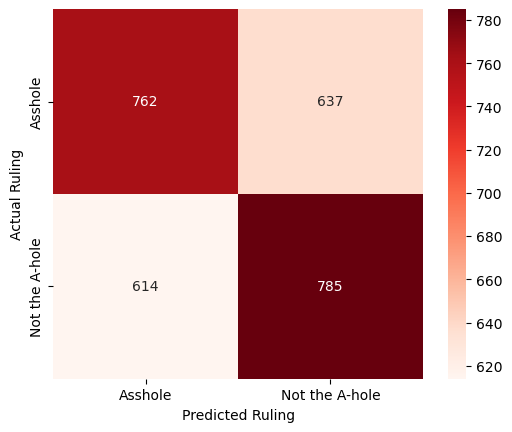

In [34]:
mat = confusion_matrix(total_test, total_pred)
sns.heatmap(mat, square=True, annot=True, fmt="d", cmap="Reds", xticklabels=["Asshole", "Not the A-hole"], yticklabels=["Asshole", "Not the A-hole"])
plt.xlabel("Predicted Ruling")
plt.ylabel("Actual Ruling")
plt.show()

I'm surprised that SVC can't do any better than MultinomialNB! I'd assume it would be the other way around. I wonder why...